In [1]:
from ecosap.ecopro import SpectralComparison
from pathlib import Path
import sqlite3
import pandas as pd
import pickle
import numpy as np
from tqdm.notebook import tqdm

# Calculate PSD's

In [2]:
conn = sqlite3.connect('../results/results.db')
cursor = conn.cursor()

unique_folders = pd.read_sql_query("SELECT DISTINCT folder FROM audios", conn)
unique_folders = unique_folders['folder'].tolist()

SIGNAL = 'whiteNoise'
AUDIOPATH = Path(f'/Users/davidluna/Documents/Audios/{SIGNAL}/splitted/')
reference_folder = ['SM04','SM02']
# GetPSD is a class that calculates the PSD of a signal
# and returns the PSD and the frequencies

for x, xfolder in enumerate(reference_folder):
    for y, yfolder in tqdm(enumerate(unique_folders), total=len(unique_folders)): 
        if xfolder == yfolder:
            continue
        folder_x = pd.read_sql_query(f"SELECT path FROM audios WHERE folder = '{xfolder}' and signal = '{SIGNAL}'", conn)
        folder_x = folder_x['path'].tolist()
        folder_y = pd.read_sql_query(f"SELECT path FROM audios WHERE folder = '{yfolder}' and signal = '{SIGNAL}'", conn)
        folder_y = folder_y['path'].tolist()

        spec_df, f  = SpectralComparison().transform(folder_x, folder_y)
        # Save the PSDs in the database
        for ind,row in spec_df.iterrows():
            
            cursor.execute("INSERT INTO spectral_comparison (psd_x, psd_y, csd_xy, freq, folder_x, folder_y, signal, n_audio) VALUES (?, ?, ?, ?, ?, ?, ?, ?)", 
            (pickle.dumps(row.sxx), pickle.dumps(row.syy), 
            pickle.dumps(row.sxy), pickle.dumps(f), xfolder,
            yfolder,SIGNAL ,ind))
        conn.commit()    
conn.close()


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

# Calculate Coherence

In [4]:
def getComparableRange(freq, coh, window_size=10):
    if np.max(freq) < window_size:
        raise Exception('Window size is bigger than the array size')

    if isinstance(coh, list):
        coh = np.array(coh)
    
    if isinstance(freq, list):
        freq = np.array(freq)

    ws_coh = []
    threshold = np.median(coh)
    for i in range(0, int(np.max(freq)), window_size):
        wcoh = coh[np.logical_and(freq >= i, freq < i+window_size)]
        ws_coh.extend([wcoh.mean()]*len(wcoh))

    if len(ws_coh) < len(coh):
        ws_coh.extend([ws_coh[-1]]*(len(coh)-len(ws_coh)))

    mask = ws_coh >= threshold

    startFreqRange = []
    endFreqRange = []
    for i in range(len(mask)):
        if i==0:
            if not mask[i]:
                freq_val = int(freq[i]/1000)
                startFreqRange.append(freq_val*1000)
        else:
            if not mask[i] and mask[i-1]:
                freq_val = int(freq[i]/1000)
                startFreqRange.append(freq_val*1000)
            elif mask[i] and not mask[i-1]:
                freq_val = int(freq[i]/1000)
                endFreqRange.append(freq_val*1000)

    if len(startFreqRange) > len(endFreqRange):
        freq_val = int(freq[-1]/1000)
        endFreqRange.append(freq_val*1000)

    return np.array(ws_coh), np.array(startFreqRange), np.array(endFreqRange)

In [5]:
def range2text(startFreqRange, endFreqRange):
    text = ''
    for i in range(len(startFreqRange)):
        text += f'{startFreqRange[i]}k-{endFreqRange[i]}k \n'
    return text

In [8]:
conn = sqlite3.connect('../results/results.db')
cursor = conn.cursor()

unique_folders = pd.read_sql_query("SELECT DISTINCT folder FROM audios", conn)
unique_folders = unique_folders['folder'].tolist()
BANDWIDTH = 1000
SIGNAL = 'chirp'
reference_folder = ['SM04','SM02']


for x, xfolder in enumerate(reference_folder):
    for y, yfolder in tqdm(enumerate(unique_folders),total=len(unique_folders)):
        if xfolder == yfolder:
            continue

        spc_xy = pd.read_sql_query(f"SELECT * FROM spectral_comparison WHERE folder_x = '{xfolder}' AND folder_y = '{yfolder}' and signal = '{SIGNAL}'", conn)
        spc_xy['freq'] = spc_xy['freq'].apply(pickle.loads)
        freq = spc_xy.freq[0]

        spc_xy['psd_x'] = spc_xy['psd_x'].apply(pickle.loads)
        spc_xy['psd_y'] = spc_xy['psd_y'].apply(pickle.loads)
        spc_xy['csd_xy'] = spc_xy['csd_xy'].apply(pickle.loads)

        Pxx = np.array([np.real(x) for x in spc_xy.psd_x]).mean(axis=0)
        Pyy = np.array([np.real(x) for x in spc_xy.psd_y]).mean(axis=0)
        Pxy = np.array([np.real(x) for x in spc_xy.csd_xy]).mean(axis=0)

        coh = abs(Pxy)/(np.sqrt(Pxx)*np.sqrt(Pyy))
        coh_mean = np.median(coh)

        
        coh_mean, startRange, EndRange = getComparableRange(freq,coh.ravel(), BANDWIDTH)

        # Save the PSDs in the database
        cursor.execute(f"INSERT INTO comparable_frequency_range (start_freq, end_freq, folder_x, folder_y, signal, bandwidth) VALUES (? , ?, ?, ?, ?, ?)", (pickle.dumps(startRange),pickle.dumps(EndRange), xfolder, yfolder, SIGNAL, BANDWIDTH ))
        conn.commit()
conn.close()
        

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

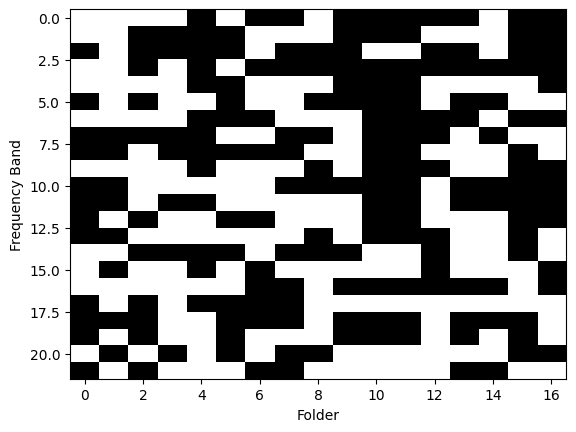

In [9]:
import matplotlib.pyplot as plt

conn = sqlite3.connect('../results/results.db')
cursor = conn.cursor()

unique_folders = pd.read_sql_query("SELECT DISTINCT folder FROM audios", conn)
unique_folders = unique_folders['folder'].tolist()

reference_folder = ['SM04','SM02']

SIGNAL = 'pinkNoise'
BANDWIDTH = 1000

comparable = np.zeros((len(unique_folders), len(np.arange(0, 22000, BANDWIDTH))))
for x, xfolder in enumerate(reference_folder):
    for y, yfolder in enumerate(unique_folders):
        if xfolder == yfolder:
            continue
        cfr = pd.read_sql_query(f"SELECT * FROM comparable_frequency_range WHERE folder_x = '{xfolder}' AND folder_y = '{yfolder}' and signal = '{SIGNAL}' and bandwidth = {BANDWIDTH}", conn)
        if len(cfr) > 0:
            start_freq = pickle.loads(cfr['start_freq'].iloc[0])
            end_freq = pickle.loads(cfr['end_freq'].iloc[0])
            for i in range(len(start_freq)):
                start = start_freq[i]
                end = end_freq[i]
                start_idx = int(start/BANDWIDTH)
                end_idx = int(end/BANDWIDTH)
                comparable[y, start_idx:end_idx] = 1

plt.imshow(comparable.T, cmap='gray', aspect='auto')
plt.ylabel('Frequency Band')
plt.xlabel('Folder')

plt.show()
